## 📦 Setup

In [23]:
# Imports
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
from pathlib import Path

# ATS Checker imports
from ats_checker.pdf_parser import extract_text_from_pdf
from ats_checker.embedding_analyzer import EmbeddingAnalyzer, EmbeddingResult
from ats_checker.llm_analyzer import OllamaAnalyzer
from ats_checker.resume_generator import ResumeAdapter
from ats_checker.cot_enhancer import ChainOfThoughtEnhancer, enhance_with_cot
from ats_checker.evaluation.test_dataset import TEST_CASES
from ats_checker.evaluation.embedding_eval import evaluate_embeddings, print_evaluation_report
from ats_checker.evaluation.enhancement_eval import evaluate_enhancement_chain

print("✅ Imports OK")

✅ Imports OK


## 📄 Load Data

In [ ]:
# Load your resume - CHANGE THE PATH!
RESUME_PATH = "/Volumes/Samsung_T5/giordano_alvari_senior_ds.pdf"

resume_text = extract_text_from_pdf(RESUME_PATH)
print(f"📄 Resume loaded: {len(resume_text)} chars, {len(resume_text.split())} words")
print("\n--- Preview ---")
print(resume_text[:1000])

📄 Resume loaded: 2648 chars, 368 words

--- Preview ---
Last updated in October 2025
Giordano Alvari
+ Florence (Italy) # giordano.alvari@gmail.com (cid:132) +39-3489133691 (cid:240) giordanoalvari § dhonveli
Senior Data Scientist | Forecasting, MLOps, and AI Systems
Experienced in designing scalable ML and forecasting systems in production on AWS. Passionate about building robust
data pipelines and explainable models to support strategic business decisions. Proven ability to lead cross-functional
teams, mentor peers, and bridge technical and business goals.
Experience
Enel, Senior Data Scientist Florence, ITJune 2023–present
• Led the development of a global hierarchical churn forecasting system with con-
formal prediction on AWS, saving up to €300 M annually through improved demand
planning and churn risk monitoring. Stack: Statsmodels, Skforecast, Nixtla, Spark,
Fast API, Pydantic.
• Designed and deployedan AI assistant using Retrieval-Augmented Generation(RAG)
to streamline interna

In [ ]:
# Fetch Job Description from LinkedIn
from ats_checker.job_scraper import scrape_job_description

# LinkedIn job URL - CHANGE WITH YOUR OWN!
LINKEDIN_URL = "https://www.linkedin.com/jobs/view/3930437766/"

print("🔍 Fetching job description from LinkedIn...")
job_result = scrape_job_description(LINKEDIN_URL)

if job_result:
    JOB_DESCRIPTION = job_result
    print(f"✅ Job Description loaded: {len(JOB_DESCRIPTION)} chars")
    print("\n--- Preview ---")
    print(JOB_DESCRIPTION[:1000])
else:
    print(f"❌ Error: {job_result['error']}")
    # Fallback to manual input
    JOB_DESCRIPTION = """
    PASTE HERE THE JOB DESCRIPTION IF FETCH FAILS
    """

🔍 Fetching job description from LinkedIn...
✅ Job Description loaded: 3125 chars

--- Preview ---
Job Title: Data Scientist
Company: company website

Are you looking for a new challenge?
Fancy helping us shape the future of motor insurance?
Prima could be the place for you.
Since 2015, we’ve been using our love of data and tech to rethink motor insurance and bring drivers a great experience at a great price. Our story began in Italy, where we’ve quickly become the number one online motor insurance provider. In fact, we’re trusted by over 4 million drivers. And now we’re expanding to help millions more drivers in the UK and Spain.
To help fuel that growth, we need a
Data Scientist
to join our
Italian Pricing & Underwriting team
, that is the strategic engine behind Prima's growth.
As part of this team, you’ll play a pivotal role in shaping our strategy and strengthening our competitive edge. Using data, analytical thinking, machine learning and business acumen, you’ll help predict the f

---
# 🧪 Part 1: Embedding Analysis

Test different aspects of embeddings

## 1.1 Basic Embedding Analysis

In [33]:
# Initialize analyzer
analyzer = EmbeddingAnalyzer(embedding_model="nomic-embed-text")

# Analyze
result = analyzer.analyze(resume_text, JOB_DESCRIPTION)

print("📊 EMBEDDING ANALYSIS RESULTS")
print("=" * 50)
print(f"\n🎯 Raw Similarity Score: {result.overall_similarity:.1f}%")
print(f"🎯 Adjusted Score (with penalties): {result.adjusted_score:.1f}%")
print(f"🔑 Keyword Overlap: {result.keyword_overlap:.1f}%")
print(f"🏷️ Domain Match: {result.domain_match}")

print("\n📁 Section Scores:")
for section, score in result.section_scores.items():
    print(f"  - {section}: {score:.1f}%")

print("\n✅ Strong Matches:")
for match in result.strong_matches:
    print(f"  - {match[:80]}..." if len(match) > 80 else f"  - {match}")

print("\n⚠️ Semantic Gaps:")
for gap in result.semantic_gaps:
    print(f"  - {gap[:80]}..." if len(gap) > 80 else f"  - {gap}")

📊 EMBEDDING ANALYSIS RESULTS

🎯 Raw Similarity Score: 84.8%
🎯 Adjusted Score (with penalties): 64.8%
🔑 Keyword Overlap: 50.0%
🏷️ Domain Match: True

📁 Section Scores:
  - experience: 85.3%
  - education: 80.8%
  - skills: 80.1%

✅ Strong Matches:
  - Job Title: Data Scientist
  - Fancy helping us shape the future of motor insurance?
  - Since 2015, we’ve been using our love of data and tech to rethink motor insuranc...
  - Our story began in Italy, where we’ve quickly become the number one online motor...
  - In fact, we’re trusted by over 4 million drivers

⚠️ Semantic Gaps:
  - Missing skill: rust
  - Missing skill: statistics


## 1.2 Raw Embedding Vectors

In [34]:
# Get raw embeddings for analysis
resume_emb = analyzer.get_embedding(resume_text[:2000])
job_emb = analyzer.get_embedding(JOB_DESCRIPTION)

print(f"📐 Resume embedding shape: {len(resume_emb)} dimensions")
print(f"📐 Job embedding shape: {len(job_emb)} dimensions")

# Convert to numpy for analysis
resume_vec = np.array(resume_emb)
job_vec = np.array(job_emb)

# Statistics
print(f"\n📊 Resume embedding stats:")
print(f"  Mean: {resume_vec.mean():.4f}, Std: {resume_vec.std():.4f}")
print(f"  Min: {resume_vec.min():.4f}, Max: {resume_vec.max():.4f}")

# Cosine similarity
cosine_sim = analyzer.cosine_similarity(resume_emb, job_emb)
print(f"\n🎯 Cosine Similarity: {cosine_sim:.4f}")

📐 Resume embedding shape: 768 dimensions
📐 Job embedding shape: 768 dimensions

📊 Resume embedding stats:
  Mean: 0.0003, Std: 0.0361
  Min: -0.1901, Max: 0.1410

🎯 Cosine Similarity: 0.6965


## 1.3 Visualize Embeddings (PCA)

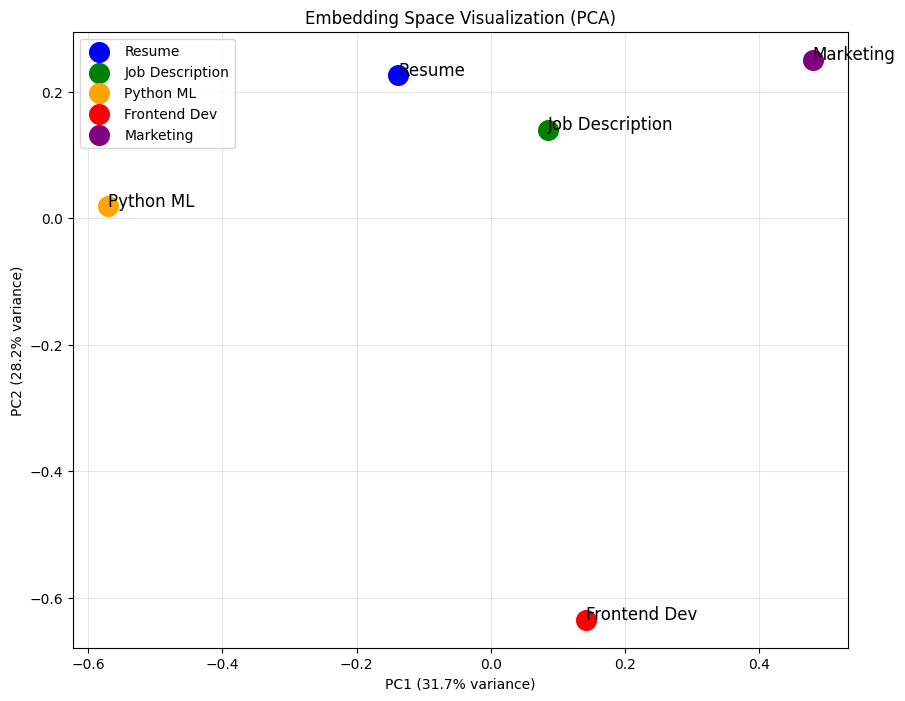

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get embeddings for multiple texts
texts = {
    "Resume": resume_text[:1500],
    "Job Description": JOB_DESCRIPTION,
    "Python ML": "Python machine learning data science pandas scikit-learn tensorflow pytorch",
    "Frontend Dev": "React JavaScript TypeScript HTML CSS frontend web development",
    "Marketing": "Marketing campaign brand strategy social media advertising lead generation",
}

embeddings = []
labels = []
for label, text in texts.items():
    emb = analyzer.get_embedding(text)
    embeddings.append(emb)
    labels.append(label)

# PCA to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, (label, color) in enumerate(zip(labels, colors)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=color, s=200, label=label)
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=12)

plt.title("Embedding Space Visualization (PCA)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
TEST_CASES

[TestCase(resume='\nSenior Data Scientist | 6 Years Experience\n\nEXPERIENCE:\n- Lead Data Scientist at TechCorp (2020-2024)\n  • Built ML models for demand forecasting using Prophet and LSTM\n  • Deployed models on AWS SageMaker with CI/CD pipelines\n  • Mentored team of 3 junior data scientists\n  • Reduced forecast error by 35% saving $2M annually\n\nSKILLS:\nPython, PyTorch, TensorFlow, AWS (S3, SageMaker, Lambda), Spark, SQL, MLOps, Docker, Kubernetes\n\nEDUCATION:\nMSc Machine Learning, Stanford University\n        ', job="\nSenior Data Scientist - ML Platform\n\nWe're looking for a Senior Data Scientist to join our ML team.\n\nResponsibilities:\n- Design and deploy ML models in production\n- Build forecasting systems for demand planning\n- Work with AWS (S3, SageMaker, Lambda)\n- Develop MLOps pipelines with CI/CD\n- Mentor junior data scientists\n\nRequirements:\n- 5+ years in data science\n- Strong Python (pandas, scikit-learn, PyTorch)\n- Time series forecasting experience\n-

## 1.4 Evaluate on Test Dataset

In [49]:
# Run evaluation on test dataset
print("🧪 Running evaluation on 12 test cases...")
print("=" * 60)

eval_result = evaluate_embeddings(TEST_CASES, threshold=50.0, verbose=True)
print_evaluation_report(eval_result, "nomic-embed-text")

🧪 Running evaluation on 12 test cases...
  Testing case 1/12: exact_match... ⚠️ Expected: 90, Got: 69.9, Error: 20.1
  Testing case 2/12: exact_match... ✅ Expected: 88, Got: 80.1, Error: 7.9
  Testing case 3/12: partial_match... ⚠️ Expected: 65, Got: 81.9, Error: 16.9
  Testing case 4/12: partial_match... ✅ Expected: 55, Got: 42.4, Error: 12.6
  Testing case 5/12: partial_match... ❌ Expected: 40, Got: 80.9, Error: 40.9
  Testing case 6/12: mismatch... ✅ Expected: 15, Got: 28.2, Error: 13.2
  Testing case 7/12: mismatch... ❌ Expected: 10, Got: 35.0, Error: 25.0
  Testing case 8/12: mismatch... ✅ Expected: 12, Got: 26.7, Error: 14.7
  Testing case 9/12: domain_switch... ⚠️ Expected: 60, Got: 78.4, Error: 18.4
  Testing case 10/12: domain_switch... ✅ Expected: 75, Got: 84.9, Error: 9.9
  Testing case 11/12: seniority_mismatch... ❌ Expected: 25, Got: 60.2, Error: 35.2
  Testing case 12/12: seniority_mismatch... ❌ Expected: 30, Got: 60.1, Error: 30.1

EVALUATION REPORT: nomic-embed-text

📊 

## 1.5 🧪 Experiment: Try Different Embedding Models

In [50]:
# Test different models (make sure they're installed via: ollama pull <model>)
# Available embedding models: nomic-embed-text, mxbai-embed-large, all-minilm

MODELS_TO_TEST = [
    "nomic-embed-text",
    "mxbai-embed-large",
    "bge-large",
    # "mxbai-embed-large",  # Uncomment if installed
]

results = {}
for model in MODELS_TO_TEST:
    print(f"\n🔄 Testing: {model}")
    try:
        test_analyzer = EmbeddingAnalyzer(embedding_model=model)
        test_result = test_analyzer.analyze(resume_text, JOB_DESCRIPTION)
        results[model] = {
            "raw_score": test_result.overall_similarity,
            "adjusted_score": test_result.adjusted_score,
            "keyword_overlap": test_result.keyword_overlap,
        }
        print(f"  ✅ Raw: {test_result.overall_similarity:.1f}%, Adjusted: {test_result.adjusted_score:.1f}%")
    except Exception as e:
        print(f"  ❌ Error: {e}")

# Compare results
if results:
    df = pd.DataFrame(results).T
    display(df)


🔄 Testing: nomic-embed-text
  ✅ Raw: 84.8%, Adjusted: 64.8%

🔄 Testing: mxbai-embed-large
  ✅ Raw: 84.5%, Adjusted: 64.5%

🔄 Testing: bge-large
  ✅ Raw: 84.5%, Adjusted: 64.5%


,raw_score,adjusted_score,keyword_overlap
nomic-embed-text,84.8,64.8,50.0
mxbai-embed-large,84.5,64.5,50.0
bge-large,84.5,64.5,50.0


---
# 🚀 Part 2: Resume Enhancement

Test different resume optimization strategies

## 2.1 Basic Enhancement (Old Method)

In [51]:
# Old method - single-pass enhancement
llm_analyzer = OllamaAnalyzer(model="qwen2.5:7b-instruct")
adapter = ResumeAdapter(analyzer=llm_analyzer)

# Get gaps from embedding analysis
embedding_gaps = result.semantic_gaps
missing_keywords = ["mlops", "ci/cd", "sagemaker"]

print("🔄 Generating enhanced resume (old method)...")
old_result = adapter.generate_full_adapted_resume(
    resume_text=resume_text,
    job_text=JOB_DESCRIPTION,
    embedding_gaps=embedding_gaps,
    missing_keywords=missing_keywords,
)

print(f"\n📝 Changes made: {len(old_result.changes_made)}")
for change in old_result.changes_made:
    print(f"  - {change}")

🔄 Generating enhanced resume (old method)...

📝 Changes made: 1
  - Full resume optimization for job alignment


In [52]:
old_result

AdaptedResume(original_text='Last updated in October 2025\nGiordano Alvari\n+ Florence (Italy) # giordano.alvari@gmail.com (cid:132) +39-3489133691 (cid:240) giordanoalvari § dhonveli\nSenior Data Scientist | Forecasting, MLOps, and AI Systems\nExperienced in designing scalable ML and forecasting systems in production on AWS. Passionate about building robust\ndata pipelines and explainable models to support strategic business decisions. Proven ability to lead cross-functional\nteams, mentor peers, and bridge technical and business goals.\nExperience\nEnel, Senior Data Scientist Florence, ITJune 2023–present\n• Led the development of a global hierarchical churn forecasting system with con-\nformal prediction on AWS, saving up to €300 M annually through improved demand\nplanning and churn risk monitoring. Stack: Statsmodels, Skforecast, Nixtla, Spark,\nFast API, Pydantic.\n• Designed and deployedan AI assistant using Retrieval-Augmented Generation(RAG)\nto streamline internal documentati

## 2.2 Chain-of-Thought Enhancement (New Method)

In [53]:
# New method - Chain-of-Thought with fact preservation
cot_enhancer = ChainOfThoughtEnhancer(
    model="qwen2.5:7b-instruct",
    strict_fact_preservation=True
)

print("🧠 Generating enhanced resume (CoT method)...")
cot_result = cot_enhancer.enhance_resume(
    resume_text=resume_text,
    job_description=JOB_DESCRIPTION,
    embedding_gaps=embedding_gaps,
    missing_keywords=missing_keywords,
)

print(f"\n📊 Quality Score: {cot_result.quality_score:.0f}/100")
print(f"\n📝 Changes made: {len(cot_result.changes_made)}")
for change in cot_result.changes_made:
    print(f"  - {change}")

print(f"\n✅ Facts preserved: {len(cot_result.preserved_facts)}")
for fact in cot_result.preserved_facts[:10]:
    print(f"  {fact}")

🧠 Generating enhanced resume (CoT method)...

📊 Quality Score: 100/100

📝 Changes made: 4
  - Added keywords to Header: forecasting systems, data pipeline development, explainable AI models
  - Added keywords to Experience: statistics, continuous integration, deployment processes
  - Added keywords to Education: data analysis, statistical methods, workflow automation
  - Added keywords to Languages: Python, R, SQL: time series forecasting, distributed computing, data visualization

✅ Facts preserved: 9
  ✅ dates: 20
  ✅ dates: 20
  ✅ percentages: 15%
  ✅ money: €2.2 M
  ✅ money: €300 M
  ✅ numbers: 300 M
  ✅ numbers: 2.2 M
  ✅ numbers: 18 M
  ✅ dates: 20


In [45]:
cot_result

ChainOfThoughtResult(full_text='Last updated in October 2025  \nGiordano Alvari  \n+ Florence (Italy) # giordano.alvari@gmail.com  \n+39-3489133691  \ngiordanoalvari § dhonveli\n\nSenior Data Scientist | Forecasting, MLOps, and AI Systems  \nExperienced in designing scalable systems and robust data pipelines on AWS. Passionate about developing explainable models and applying statistical methods to support strategic business decisions. Proven ability to lead cross-functional teams, mentor peers, and bridge technical and business goals.\n\nExperience\n\nEnel, Senior Data Scientist Florence, ITJune 2023–present\n• Led the development of a global hierarchical churn forecasting system with conformal prediction on AWS, saving up to €300 M annually through enhanced demand planning and churn risk monitoring. Stack: Statsmodels, Skforecast, Nixtla, Spark, Fast API, Pydantic.\n• Designed and deployed an AI assistant using Retrieval-Augmented Generation (RAG) to streamline internal documentation 

## 2.3 Compare Enhancement Methods

In [46]:
# Evaluate both methods
print("📊 Evaluating OLD method...")
old_metrics = evaluate_enhancement_chain(
    original=resume_text,
    enhanced=old_result.adapted_text,
    job_description=JOB_DESCRIPTION,
    target_keywords=missing_keywords,
    print_report=True
)

print("\n" + "=" * 60)
print("📊 Evaluating NEW (CoT) method...")
cot_metrics = evaluate_enhancement_chain(
    original=resume_text,
    enhanced=cot_result.full_text,
    job_description=JOB_DESCRIPTION,
    target_keywords=missing_keywords,
    print_report=True
)

📊 Evaluating OLD method...

ENHANCEMENT EVALUATION REPORT

📈 SIMILARITY IMPROVEMENT
  Original Score:  84.8%
  Enhanced Score:  84.3%
  Improvement:     🔴 -0.5%

🔒 FACT PRESERVATION: 44%
  Dates preserved:       ✅
  Numbers preserved:     ❌
  Percentages preserved: ✅

  ⚠️ Missing facts:
    money: €2.2 M, €300 M
    numbers_with_units: 300 M, 2.2 M, 18 M

🎯 KEYWORD INCORPORATION: 100%
  Keywords found: 3/3

📏 LENGTH CHANGE: +8.0%
  Original: 2,648 chars
  Enhanced: 2,861 chars

SCORING BREAKDOWN
  Similarity Improvement: 0.0/30
  Fact Preservation:      22.2/50
  Keyword Incorporation:  20.0/20

❌ OVERALL ENHANCEMENT SCORE: 42/100 (D Poor)

📊 Evaluating NEW (CoT) method...

ENHANCEMENT EVALUATION REPORT

📈 SIMILARITY IMPROVEMENT
  Original Score:  84.8%
  Enhanced Score:  85.5%
  Improvement:     🟡 +0.7%

🔒 FACT PRESERVATION: 100%
  Dates preserved:       ✅
  Numbers preserved:     ✅
  Percentages preserved: ✅

🎯 KEYWORD INCORPORATION: 33%
  Keywords found: 1/3

📏 LENGTH CHANGE: +24.2

In [47]:
# Side-by-side comparison
comparison = pd.DataFrame({
    "Metric": [
        "Similarity Improvement",
        "Fact Preservation %",
        "Keyword Incorporation %",
        "Length Change %"
    ],
    "Old Method": [
        f"{old_metrics.similarity_improvement:+.1f}%",
        f"{old_metrics.fact_preservation_score:.0f}%",
        f"{old_metrics.keyword_incorporation:.0f}%",
        f"{old_metrics.length_change_percent:+.1f}%"
    ],
    "CoT Method": [
        f"{cot_metrics.similarity_improvement:+.1f}%",
        f"{cot_metrics.fact_preservation_score:.0f}%",
        f"{cot_metrics.keyword_incorporation:.0f}%",
        f"{cot_metrics.length_change_percent:+.1f}%"
    ]
})

print("\n📊 COMPARISON: Old vs Chain-of-Thought")
display(comparison)


📊 COMPARISON: Old vs Chain-of-Thought


,Metric,Old Method,CoT Method
0,Similarity Improvement,-0.5%,+0.7%
1,Fact Preservation %,44%,100%
2,Keyword Incorporation %,100%,33%
3,Length Change %,+8.0%,+24.2%


## 2.4 View Enhanced Resume

In [48]:
# View the CoT enhanced resume
print("📄 ENHANCED RESUME (Chain-of-Thought)")
print("=" * 60)
print(cot_result.full_text[:4000])

📄 ENHANCED RESUME (Chain-of-Thought)
Last updated in October 2025  
Giordano Alvari  
+ Florence (Italy) # giordano.alvari@gmail.com  
+39-3489133691  
giordanoalvari § dhonveli

Senior Data Scientist | Forecasting, MLOps, and AI Systems  
Experienced in designing scalable systems and robust data pipelines on AWS. Passionate about developing explainable models and applying statistical methods to support strategic business decisions. Proven ability to lead cross-functional teams, mentor peers, and bridge technical and business goals.

Experience

Enel, Senior Data Scientist Florence, ITJune 2023–present
• Led the development of a global hierarchical churn forecasting system with conformal prediction on AWS, saving up to €300 M annually through enhanced demand planning and churn risk monitoring. Stack: Statsmodels, Skforecast, Nixtla, Spark, Fast API, Pydantic.
• Designed and deployed an AI assistant using Retrieval-Augmented Generation (RAG) to streamline internal documentation access a

---
# 🧪 Part 3: Custom Experiments

Space for your own experiments!

## 3.1 🧪 Experiment: Custom Prompts

In [ ]:
# Experiment with custom prompts
import ollama

def custom_enhance(section_text: str, keywords: list[str], custom_prompt: str) -> str:
    """Enhance a section with a custom prompt."""
    prompt = custom_prompt.format(
        section=section_text,
        keywords=", ".join(keywords)
    )
    
    response = ollama.chat(
        model="qwen2.5:7b-instruct",
        messages=[{"role": "user", "content": prompt}]
    )
    return response["message"]["content"]

# Example custom prompt - MODIFY THIS!
MY_CUSTOM_PROMPT = """
Rewrite this CV section for a Data Scientist role.

ORIGINAL SECTION:
{section}

KEYWORDS TO INCORPORATE:
{keywords}

RULES:
1. Keep ALL numbers, dates and metrics exactly as they are
2. Use strong action verbs (developed, led, optimized, etc.)
3. Incorporate keywords naturally
4. DO NOT invent new experiences

OUTPUT only the rewritten section:
"""

# Test on a section
test_section = resume_text[:500]
enhanced = custom_enhance(test_section, ["MLOps", "AWS", "production ML"], MY_CUSTOM_PROMPT)
print("🔄 Custom Enhanced:")
print(enhanced)

## 3.2 🧪 Experiment: Similarity Threshold Tuning

In [ ]:
# Test different similarity thresholds
thresholds = [30, 40, 50, 60, 70]
threshold_results = []

for thresh in thresholds:
    eval_res = evaluate_embeddings(TEST_CASES, threshold=thresh, verbose=False)
    threshold_results.append({
        "threshold": thresh,
        "accuracy": eval_res.accuracy,
        "precision": eval_res.precision,
        "recall": eval_res.recall,
        "f1": eval_res.f1
    })

df_thresh = pd.DataFrame(threshold_results)
print("📊 Performance by Threshold:")
display(df_thresh)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_thresh["threshold"], df_thresh["accuracy"], "o-", label="Accuracy")
plt.plot(df_thresh["threshold"], df_thresh["f1"], "s-", label="F1 Score")
plt.plot(df_thresh["threshold"], df_thresh["precision"], "^-", label="Precision")
plt.plot(df_thresh["threshold"], df_thresh["recall"], "d-", label="Recall")
plt.xlabel("Similarity Threshold")
plt.ylabel("Score")
plt.title("Classification Performance by Threshold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3.3 🧪 Experiment: Section-by-Section Enhancement

In [ ]:
# Analyze each section separately
from ats_checker.evaluation.resume_chunker import chunk_resume, print_resume_structure

sections = chunk_resume(resume_text)
print_resume_structure(sections)

# Analyze each section against job
print("\n📊 Section Similarity Scores:")
for section in sections:
    if len(section.content) > 50:
        section_emb = analyzer.get_embedding(section.content)
        job_emb = analyzer.get_embedding(JOB_DESCRIPTION)
        sim = analyzer.cosine_similarity(section_emb, job_emb)
        score = (sim + 1) / 2 * 100
        print(f"  {section.name}: {score:.1f}%")

## 3.4 💾 Save Results

In [ ]:
# Save enhanced resume to file
output_dir = Path("../outputs")
output_dir.mkdir(exist_ok=True)

# Save CoT enhanced resume
with open(output_dir / "enhanced_resume_cot.txt", "w") as f:
    f.write(cot_result.full_text)

# Save old method resume
with open(output_dir / "enhanced_resume_old.txt", "w") as f:
    f.write(old_result.adapted_text)

print(f"✅ Saved to {output_dir}")

---
# 📝 Notes & Ideas

Use this section to write down your observations and improvement ideas.

### TODO:
- [ ] Test with other embedding models
- [ ] Try different prompts for enhancement
- [ ] Add more test cases to the dataset
- [ ] Experiment with hybrid scoring (TF-IDF + embeddings)
- [ ] ...